# **Modelos MLPRegressor**

## Objetivo:
**Predicción de la volatilidad histórica**

* Inputs: Lags de retornos logarítmicos del precio de Bitcoin.
* Output: Volatilidad futura en el horizonte de 7 días.

In [1]:
# [Configuración] Importaciones

# Manipulación de datos
import numpy as np
import pandas as pd

# Modelado
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tsxv.splitTrainValTest import split_train_val_test_groupKFold

# Visualización
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 16,         
    'axes.titleweight': 'bold',   
    'font.family': 'Tahoma', 
})

# Otros
import time
import joblib
import os

## Modelado

In [2]:
# [Configuración] Lectura de archivo y selección de variables de interés
btc = pd.read_csv(r"C:\Users\Hp\MACHINE\MINI_PRY_2\data\BTC_all.csv") 
WINDOW_SIZES = [7, 14, 21, 28]
colores_por_ventana = { 7: '#377D71',14: '#FBC5C5', 21: '#FBA1A1', 28: '#8879B0'}


In [3]:
# [Función] Calcular métricas
def compute_metrics(y_true, y_pred):
    metrics = {"Horizon": [], "MAE": [], "MSE": [], "RMSE": []}
    residuos_dict = {}

    for h in range(7):
        y_t = y_true[:, h]
        y_p = y_pred[:, h]
        resid = y_t - y_p

        mae = mean_absolute_error(y_t, y_p)
        mse = mean_squared_error(y_t, y_p)
        rmse = np.sqrt(mse)

        metrics["Horizon"].append(h+1)
        metrics["MAE"].append(mae)
        metrics["RMSE"].append(rmse)
        metrics["MSE"].append(mse)

        residuos_dict[f"h{h+1}"] = resid

    # Agregados (avg)
    metrics["Horizon"].append("avg")
    metrics["MAE"].append(np.mean(metrics["MAE"]))
    metrics["RMSE"].append(np.mean(metrics["RMSE"]))
    metrics["MSE"].append(np.mean(metrics["MSE"]))

    # Residuales globales
    residuos_dict["all"] = y_true - y_pred

    return pd.DataFrame(metrics), residuos_dict

In [4]:
# [Función] Pipeline principal
def main_pipeline(btc, objetivo):
    print(f"=========== Procesando {objetivo} =========== ")
    results = {}

    # Iterar por ventana
    for window_size in WINDOW_SIZES:
        print(f"\n{'='*60}")
        print(f"=== Procesando ventana de {window_size} días === \n Se usa un lag de {window_size} días")

        # Parámetros
        timeSeries = btc[f'Volatil_D{window_size}']
        numInputs = window_size # Máximo de lags a usar (28 días)
        numOutputs = 7 # Días en el horizonte
        numJumps = 1 # Salto de WINDOW_SIZES (1 día)
        print(f"Parámetros: numInputs={numInputs}, numOutputs={numOutputs}, numJumps={numJumps}")
        
        # Split
        X_t, Y_t, X_v, Y_v, X_st, Y_st = split_train_val_test_groupKFold(timeSeries, numInputs, numOutputs, numJumps)
        print(f" Numero de folds generados", len(X_t))
               
        fold_results = []
        start = time.time()
        # Iterar por cada fold
        for fold in range (len(X_t)):
            
            # Dividir datos
            X_train, X_val, X_test = X_t[fold], X_v[fold], X_st[fold]
            Y_train, Y_val, Y_test = Y_t[fold], Y_v[fold], Y_st[fold]

            # Escalar
            X_Scaler = StandardScaler()
            Y_Scaler = StandardScaler()

            X_train_S = X_Scaler.fit_transform(X_train)
            X_val_S = X_Scaler.transform(X_val)
            X_test_S = X_Scaler.transform(X_test)
            Y_train_S = Y_Scaler.fit_transform(Y_train)

            # Modelo
            model = MLPRegressor(
                hidden_layer_sizes=(100, 50),
                activation='relu',
                solver='adam',
                alpha=0.0001,
                learning_rate='constant',
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.1,
                random_state=42
                )
            # Modelar
            model.fit(X_train_S, Y_train_S)
            # Guardar modelo entrenado
            joblib.dump(model, f"models/{objetivo}__{window_size}d_fold{fold}.pkl")

            # Predicciones
            y_train_pred_S = model.predict(X_train_S)
            y_val_pred_S = model.predict(X_val_S)
            y_test_pred_S = model.predict(X_test_S)

            # Revertir escala
            y_train_pred = Y_Scaler.inverse_transform(y_train_pred_S)
            y_val_pred = Y_Scaler.inverse_transform(y_val_pred_S)
            y_test_pred = Y_Scaler.inverse_transform(y_test_pred_S)

            # Métricas en test por horizonte
            df_metrics, residuos = compute_metrics(Y_test, y_test_pred)
            df_metrics["fold"] = fold
            df_metrics["window"] = window_size

            avg_RMSE = df_metrics.loc[df_metrics["Horizon"]=="avg", "RMSE"].values[0]
            
            # Guardar resultados del fold
            fold_results.append({
                'fold': fold,
                'model': model,
                'metrics_df': df_metrics,
                'avg_RMSE': avg_RMSE,
                'residuos': residuos,
                'y_test': Y_test,
                'y_val': Y_val,
                'y_train': Y_train,
                'yhat_train': y_train_pred,
                'yhat_val': y_val_pred, 
                'yhat_test': y_test_pred,
            })

        end = time.time()
        duracion = end - start

        print(f"⏱️ Tiempo de entrenamiento folds: {duracion:.2f} segundos")
        print("Modelos entrenados guardados")

        # Concatenar métricas de folds
        df_all = pd.concat([fr["metrics_df"] for fr in fold_results], ignore_index=True)

        # Seleccionar best, worst y median fold de acuerdo al RMSE
        sorted_folds = sorted(fold_results, key=lambda x: x["avg_RMSE"])
        best_fold   = sorted_folds[0]   # menor RMSE
        worst_fold  = sorted_folds[-1]  # mayor RMSE
        median_fold = sorted_folds[len(sorted_folds) // 2]  # fold intermedio

        results[window_size] = {
            "folds": fold_results,
            "metrics": df_all,
            "best_fold": best_fold,
            "worst_fold": worst_fold,
            "median_fold": median_fold,
        }
    return results

In [5]:
# Generar carpetas
os.makedirs("figs", exist_ok=True)
os.makedirs("metricas", exist_ok=True)
os.makedirs("models", exist_ok=True)

## Ejecución

In [6]:
# Ejecución
objetivo= 'volatilidad'
results = main_pipeline(btc, objetivo)

=========== Procesando volatilidad =========== 

=== Procesando ventana de 7 días === 
 Se usa un lag de 7 días
Parámetros: numInputs=7, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 1.10 segundos
Modelos entrenados guardados

=== Procesando ventana de 14 días === 
 Se usa un lag de 14 días
Parámetros: numInputs=14, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 0.44 segundos
Modelos entrenados guardados

=== Procesando ventana de 21 días === 
 Se usa un lag de 21 días
Parámetros: numInputs=21, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 0.92 segundos
Modelos entrenados guardados

=== Procesando ventana de 28 días === 
 Se usa un lag de 28 días
Parámetros: numInputs=28, numOutputs=7, numJumps=1
 Numero de folds generados 5
⏱️ Tiempo de entrenamiento folds: 0.24 segundos
Modelos entrenados guardados


____________

### Predicciones

In [7]:
# [Tabla] Predicción de volatilidad de cada horizonte por ventana
tabla = {}
for ventana in WINDOW_SIZES:
    folds = results[ventana]["folds"]
    num_outputs = folds[0]['yhat_test'].shape[1]

    # Acumuladores por horizonte
    test_por_h = [[] for _ in range(num_outputs)]

    for fr in folds:
        for h in range(num_outputs):
            test_por_h[h].extend(fr['yhat_test'][:, h])

    # Promedios por horizonte
    test_avg = [np.mean(v) for v in test_por_h]
    test_avg.append(np.mean(test_avg))  # agregar promedio global

    # Guardar en diccionario por ventana
    tabla[ventana] = test_avg

# Crear DataFrame
indices = [f'{i+1}' for i in range(num_outputs)] + ['avg']
df = pd.DataFrame(tabla, index=indices)

filename = f"metricas/Predicted_{objetivo}_each_horizont_by_window.csv"
df.round(4).to_csv(filename, index=False)
print("✅ Archivo CSV creado en la carpeta 'metricas'")
print("Predicción por ventana")
display(df.round(4))


✅ Archivo CSV creado en la carpeta 'metricas'
Predicción por ventana


,7,14,21,28
1,0.5722,0.5859,0.6269,0.6047
2,0.5665,0.5851,0.6242,0.5671
3,0.5648,0.6178,0.6277,0.5967
4,0.5580,0.5926,0.6247,0.5876
5,0.5549,0.5961,0.6185,0.5915
6,0.5676,0.5694,0.6180,0.5714
7,0.5764,0.5894,0.6106,0.5648
avg,0.5658,0.5909,0.6215,0.5834


In [8]:
# [Tabla] Resumen numérico de la predicción de volatilidad promedio por ventana
tabla_vol = {}
ventanas = [7,14,21,28]

for dia in ventanas:
    tabla_vol[f"{dia} días"] = df[dia].describe()

df_vol = pd.DataFrame(tabla_vol).T
df_vol = df_vol[['mean', 'std', 'min', '25%', '50%', '75%', 'max']] 
df_vol = df_vol.map(lambda x: f"{x:.4f}")
df_vol

,mean,std,min,25%,50%,75%,max
7 días,0.5658,0.0069,0.5549,0.5631,0.5661,0.5687,0.5764
14 días,0.5909,0.0135,0.5694,0.5857,0.5901,0.5934,0.6178
21 días,0.6215,0.0057,0.6106,0.6184,0.6228,0.6253,0.6277
28 días,0.5834,0.0145,0.5648,0.5703,0.5855,0.5928,0.6047


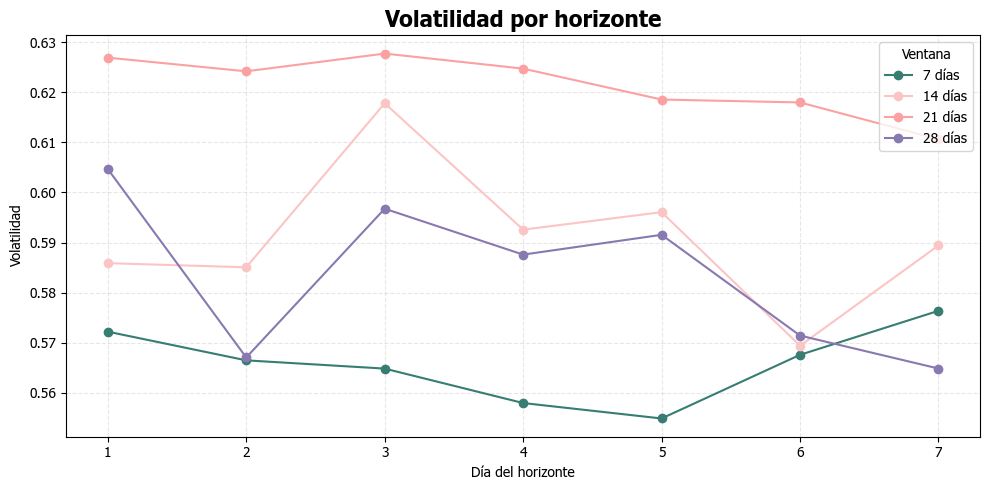

In [9]:
# [Gráfico] Predicción de volatilidad de cada horizonte por ventana

# Eliminar la fila 'avg' si no quieres graficarla
df_sin_avg = df.drop(index='avg')

# Convertir índice a entero para orden correcto
df_sin_avg.index = df_sin_avg.index.astype(int)

# Graficar
plt.figure(figsize=(10, 5))

for ventana in df_sin_avg.columns:
    color = colores_por_ventana.get(int(ventana))
    plt.plot(df_sin_avg.index, df_sin_avg[ventana], label=f'{ventana} días', marker='o', color = color)

plt.title(f'Volatilidad por horizonte')
plt.xlabel('Día del horizonte')
plt.ylabel('Volatilidad')
plt.xticks(df_sin_avg.index)
plt.legend(title='Ventana')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f"figs/Predicted_{objetivo}_each_horizont_by_window.png", dpi=300, bbox_inches="tight")
plt.show()

Las predicciones de volatilidad anualizada muestran que los modelos capturan consistentemente niveles de riesgo entre 55.4% y 62.7%, dependiendo del horizonte de cálculo. La ventana de 21 días presenta la estimación más alta, oscilando la volatilidad entre 0.61 a 0.627, además de ser la más estable, lo que sugiere que en ese horizonte se acumulan más eventos de variabilidad sostenida (media de 0.6215). La ventana de 7 días, por el contrario es la de estimación más baja, prediciendo volatilidades entre el 55.4% al 57.6%, siendo la segunda menos variable. 

Para las ventanas de 14 y 28 días, se observan que las predicciones tienen mayor variabilidad a lo largo de los días con un mayor rango de estimación.

Resumiendo el rendimiento de las ventanas, la predicción de la volatilidad tiene una media de 56.5% - 58.3%, con una desviación estándar no mayor al 1%. 

Las predicciones son coherentes entre sí, sin saltos abruptos, indicando estabilidad en el modelo.

In [10]:
# [Tabla] Resumen de métricas por ventana
for window_size, content in results.items():
    df_metrics = content["metrics"]
    print(f"\n📊 Ventana {window_size} días")
    
    # Promedio y std por horizonte
    df_summary = df_metrics.groupby("Horizon").agg(
        mae_mean=("MAE", "mean"), mae_std=("MAE", "std"),
        mse_mean=("MSE", "mean"), mse_std=("MSE", "std"),
        RMSE_mean=("RMSE", "mean"), RMSE_std=("RMSE", "std"),
    ).reset_index()

    # Guardar en CSV
    filename = f"metricas/{objetivo}_ventana_{window_size}d.csv"
    df_summary.round(4).to_csv(filename, index=False)
        
    display(df_summary.round(4))
print("✅ Archivos CSV creados en la carpeta 'metricas'")


📊 Ventana 7 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.0961,0.0348,0.0375,0.0394,0.1749,0.0928
1,2,0.1250,0.0296,0.0520,0.0475,0.2124,0.0927
2,3,0.1554,0.0245,0.0623,0.0438,0.2391,0.0804
3,4,0.1676,0.0138,0.0677,0.0429,0.2519,0.0734
4,5,0.1857,0.0154,0.0736,0.0420,0.2643,0.0684
5,6,0.2046,0.0187,0.0822,0.0448,0.2799,0.0695
6,7,0.2156,0.0102,0.0894,0.0459,0.2927,0.0680
7,avg,0.1643,0.0195,0.0664,0.0432,0.2450,0.0762



📊 Ventana 14 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.0939,0.0340,0.0176,0.0093,0.1283,0.0379
1,2,0.1100,0.0285,0.0263,0.0107,0.1585,0.0385
2,3,0.1234,0.0208,0.0441,0.0188,0.2053,0.0498
3,4,0.1168,0.0201,0.0282,0.0138,0.1643,0.0390
4,5,0.1446,0.0218,0.0342,0.0102,0.1832,0.0287
5,6,0.1382,0.0238,0.0344,0.0148,0.1823,0.0378
6,7,0.1390,0.0154,0.0345,0.0108,0.1841,0.0268
7,avg,0.1237,0.0192,0.0313,0.0090,0.1723,0.0275



📊 Ventana 21 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.0517,0.0094,0.0050,0.0018,0.0698,0.0135
1,2,0.0666,0.0075,0.0075,0.0016,0.0862,0.0091
2,3,0.0780,0.0092,0.0109,0.0026,0.1038,0.0126
3,4,0.0929,0.0215,0.0149,0.0054,0.1207,0.0203
4,5,0.0952,0.0104,0.0143,0.0015,0.1197,0.0061
5,6,0.0960,0.0064,0.0156,0.0035,0.1240,0.0145
6,7,0.1112,0.0081,0.0194,0.0035,0.1390,0.0119
7,avg,0.0845,0.0081,0.0125,0.0022,0.1090,0.0098



📊 Ventana 28 días


,Horizon,mae_mean,mae_std,mse_mean,mse_std,RMSE_mean,RMSE_std
0,1,0.1303,0.0276,0.0580,0.0368,0.2282,0.0858
1,2,0.1437,0.0171,0.0713,0.0247,0.2626,0.0537
2,3,0.1364,0.0175,0.0678,0.0286,0.2534,0.0670
3,4,0.1436,0.0214,0.0733,0.0334,0.2622,0.0749
4,5,0.1604,0.0213,0.0792,0.0322,0.2751,0.0662
5,6,0.1649,0.0281,0.0845,0.0363,0.2827,0.0753
6,7,0.1759,0.0383,0.0847,0.0383,0.2823,0.0794
7,avg,0.1507,0.0232,0.0741,0.0304,0.2638,0.0666


✅ Archivos CSV creados en la carpeta 'metricas'


Con respecto a las métricas de rendimiendo para el modelo se tienen: 
- **MAE (Mean Absolute Error)**: error promedio absoluto entre predicción y valor real.
- **MSE (Mean Squared Error)**: penaliza errores grandes, útil para detectar outliers.
- **RMSE (Root Mean Squared Error)**: raíz cuadrada del MSE, en misma escala que la variable original.

Para la ventana de 7 días, a medida que el horizonte de predicción aumenta, el error también lo hace. Aunque la variabilidad del MAE y RMSE disminuyen, lo que indica estabilidad en ejecuciones. 

Para la ventana de 14 días, se observa el mismo patrón, con un salto en el tercer día de predicción. 

La ventana de 21 días, también sigue el patrón de aumento proporcional, pero con los valores de error más bajos entre todas las ventanas. Siendo esta la mejor opción para predecir la volatilidad. 

Con respecto a las ventana de 28 días se tienen los errores RMSE más altos, con la misma tendencia de aumento. 

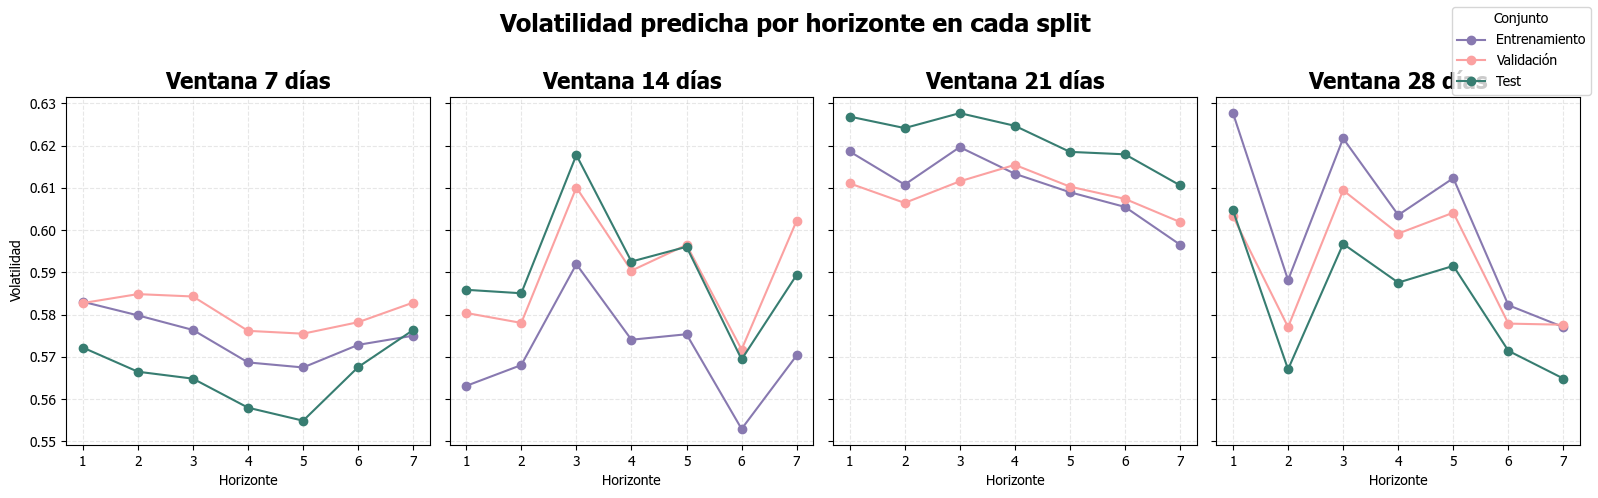

In [11]:
# [Gráfico] Predicción de volatilidad de cada horizonte por ventana por conjunto

num_WINDOW_SIZES = len(WINDOW_SIZES)
fig, axes = plt.subplots(nrows=1, ncols=num_WINDOW_SIZES, figsize=(16,5), sharey=True)

for i, ventana in enumerate(WINDOW_SIZES):
    
    folds = results[ventana]["folds"]
    num_outputs = folds[0]['yhat_test'].shape[1]

    # Inicializar acumuladores
    train_por_h = [[] for _ in range(num_outputs)]
    val_por_h = [[] for _ in range(num_outputs)]
    test_por_h = [[] for _ in range(num_outputs)]

    for fr in folds:
        for h in range(num_outputs):
            train_por_h[h].extend(fr['yhat_train'][:, h])
            val_por_h[h].extend(fr['yhat_val'][:, h])
            test_por_h[h].extend(fr['yhat_test'][:, h])

    # Calcular promedios
    train_avg = [np.mean(v) for v in train_por_h]
    val_avg = [np.mean(v) for v in val_por_h]
    test_avg = [np.mean(v) for v in test_por_h]

    horizonte = np.arange(1, num_outputs + 1)
    ax = axes[i]

    ax.plot(horizonte, train_avg, label='Entrenamiento', color='#8879B0', marker='o')
    ax.plot(horizonte, val_avg, label='Validación', color='#FBA1A1', marker='o')
    ax.plot(horizonte, test_avg, label='Test', color='#377D71', marker='o')

    ax.set_title(f'Ventana {ventana} días')
    ax.set_xlabel('Horizonte')
    if i == 0:
        ax.set_ylabel('Volatilidad')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xticks(horizonte)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Conjunto')
fig.suptitle('Volatilidad predicha por horizonte en cada split', fontsize=18, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Predicted_{objetivo}_each_horizont_by_window_by_conjunto.png", dpi=300, bbox_inches="tight")
plt.show()

La volatilidad predicha por horizonte descrita por cada split de datos indica el rendimiento por grupo, en cada ventana analizada.

Para la ventana de 7 días, como ya se había descrito, las predicciones son más bajas. Las curvas de cada conjunto están alineadas, con predicciones más altas en el conjunto de entrenamiento y menores en el de test. En cuanto a la ventana de 14 días, las predicciones son más variables, alineadas entre conjuntos, con valores mayores para el conjunto de test. La ventana de 21 días, presenta los valores de predicción más altos y menos variables. Con cercanía entre el conjunto de test y validación, indicando buena estabilidad. Por último, la ventana de 28 días las predicciones son más variables. Las tres curvas son muy similares, suavizando los horizontes más largos.

Las predicciones de volatilidad anualizada por horizonte muestran buena consistencia entre los conjuntos de entrenamiento, validación y test, lo que indica que el modelo generaliza correctamente.

_____________

### Rendimiento por split

> Predicción usando el promedio de los horizontes

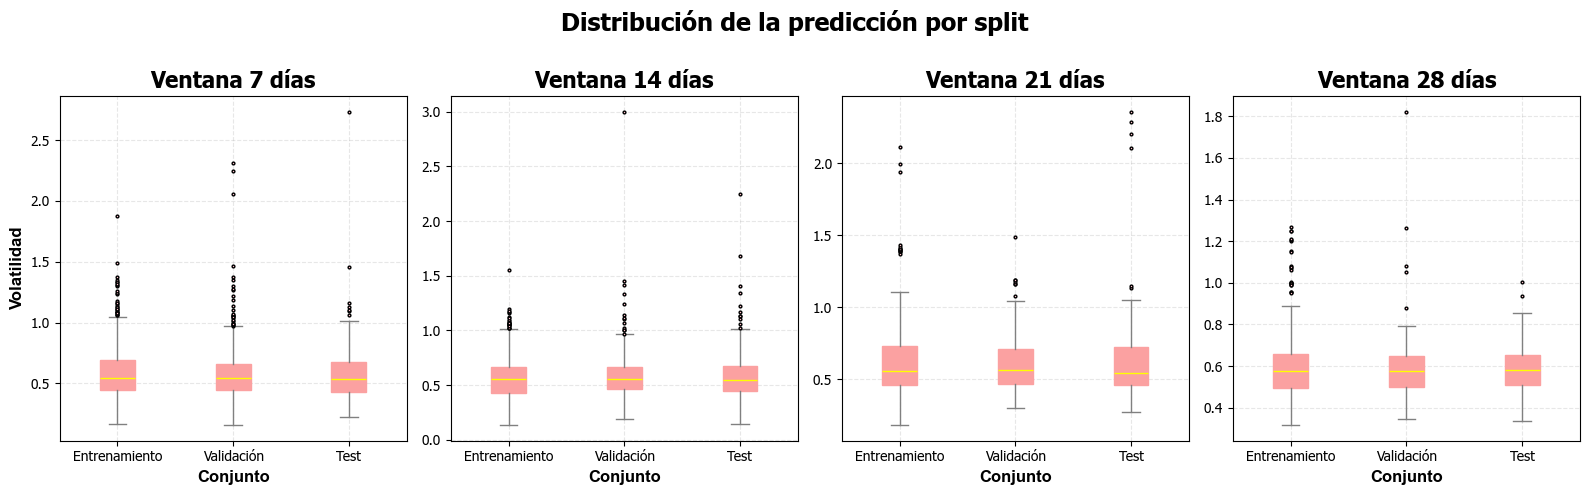

In [12]:
# [Gráfico] Volatilidad por ventana por split

fig, axes = plt.subplots(ncols=len(WINDOW_SIZES), nrows=1, figsize=(16,5))

# Si solo hay una ventana, axes no es iterable
if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]

    # Acumuladores
    train_avg = []
    val_avg = []
    test_avg = []

    for fr in folds:
        train_avg.extend(np.mean(fr['yhat_train'], axis=1))
        val_avg.extend(np.mean(fr['yhat_val'], axis=1))
        test_avg.extend(np.mean(fr['yhat_test'], axis=1))

    # Preparar datos para boxplot
    data = [train_avg, val_avg, test_avg]
    etiquetas = ['Entrenamiento', 'Validación', 'Test']

    # Graficar en subplot correspondiente
    ax = axes[i]
    ax.boxplot(data, tick_labels=etiquetas, patch_artist=True,
               boxprops=dict(facecolor='#FBA1A1', color='#FBA1A1'),
               medianprops=dict(color='yellow'),
               whiskerprops=dict(color='gray'),
               capprops=dict(color='gray'),
               flierprops=dict(marker='o', markerfacecolor='pink', markersize=2))

    ax.set_title(f'Ventana {ventana} días')
    if i == 0:
        ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_xlabel('Conjunto', fontsize=12, fontweight='bold', fontname='Arial')
    ax.grid(True, linestyle='--', alpha=0.3)
fig.suptitle('Distribución de la predicción por split', fontsize=18, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Dist_{objetivo}_each_split_by_window.png", dpi=300, bbox_inches="tight")
plt.show()

La distribución de la predicción por el split, usando el promedio de los horizontes, revela que para la ventana de 7 días el conjunto más disperso es el de test, con presencia de outliers y medianas similares. Por otro lado, la ventana de 14 días es la que mayor variación tiene, con valores más altos de volatilidad y outliers menos dispersos. La ventana de 21 días tiene medianas más altas, con mayor amplitud de cajas y menos presencia de outliers, su dispersión es moderada, siendo un balance para la sensibilidad. La ventana de 28 días tiene las distribuciones más compactas, con medianas alineadas y menos variabilidad. 

Las predicciones de volatilidad anualizada muestran buena consistencia entre los conjuntos de entrenamiento, validación y test, especialmente en ventanas largas. Las ventanas cortas presentan mayor dispersión y sensibilidad a outliers.


> Análisis para el último día de la ventana

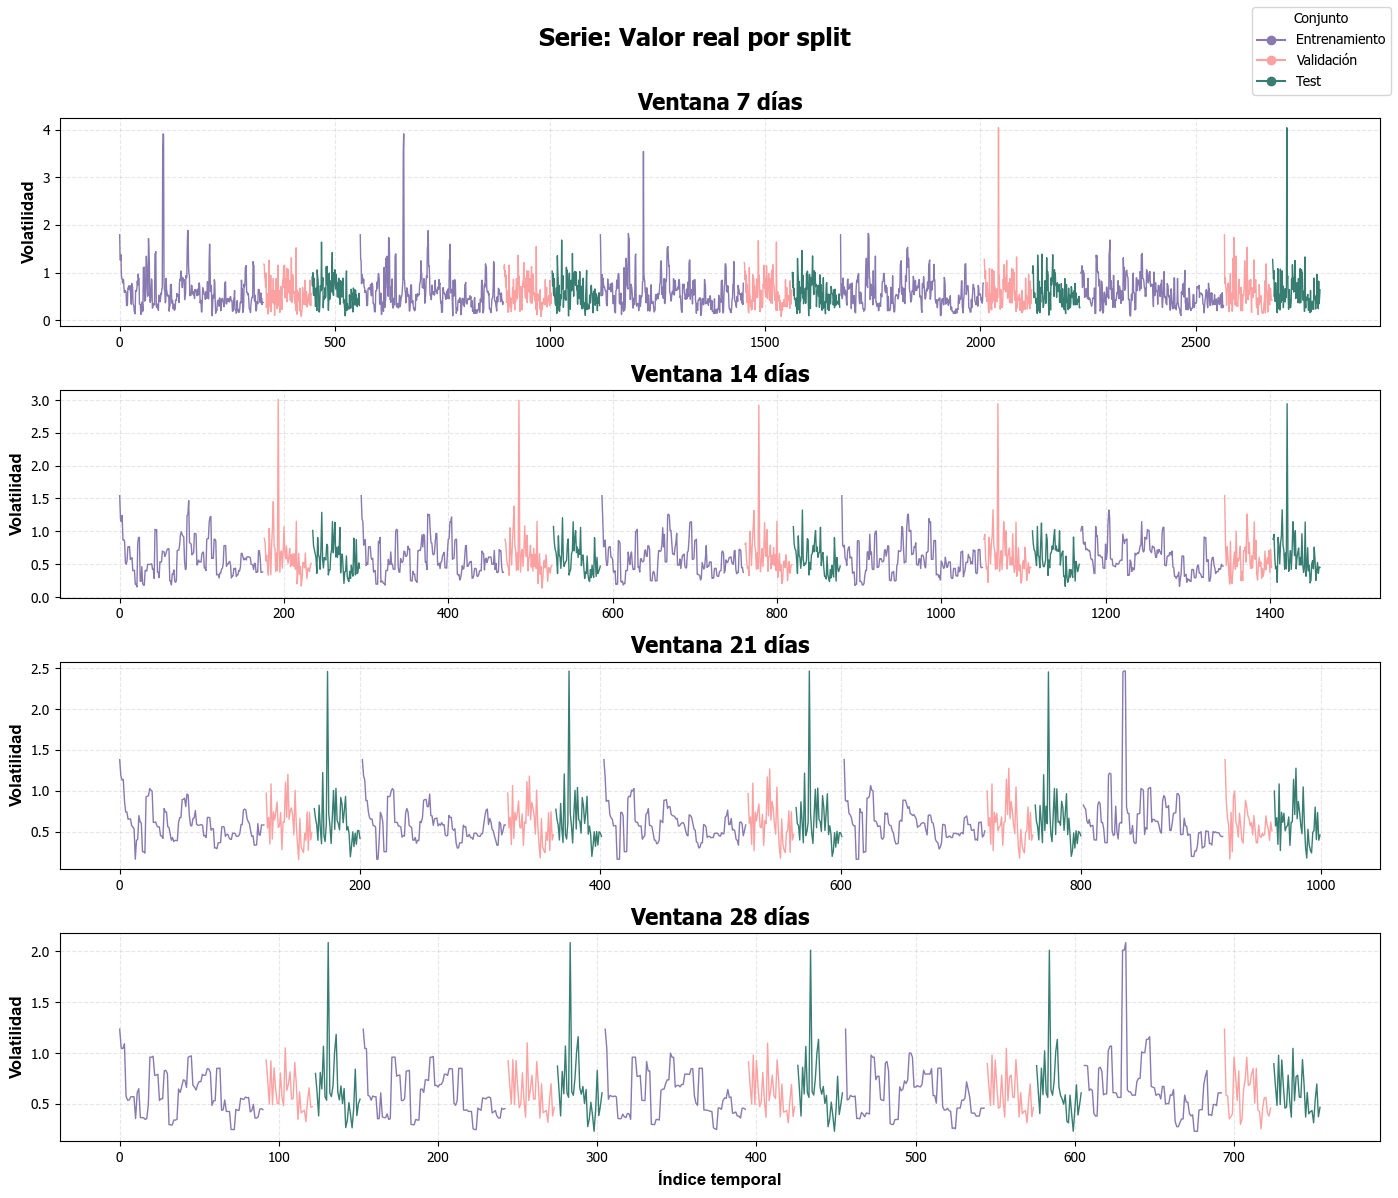

In [13]:
# [Gráfico] Serie de valor real por split

fig, axes = plt.subplots(nrows=len(WINDOW_SIZES), ncols=1, figsize=(14,12))

if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]
    ax = axes[i]
    idx = 0  # índice temporal global

    for j, fr in enumerate(folds):
        # Longitudes
        n_train = len(fr['y_train'])
        n_val = len(fr['y_val'])
        n_test = len(fr['y_test'])

        # Índices locales
        x_train = np.arange(idx, idx + n_train)
        x_val = np.arange(idx + n_train + 1, idx + n_train + 1 + n_val)
        x_test = np.arange(idx + n_train + 1 + n_val + 1, idx + n_train + 1 + n_val + 1 + n_test)

        # Graficar cada segmento por separado
        ax.plot(x_train, fr['y_train'][:,-1], color='#8879B0', label='Entrenamiento' if j == 0 else "", linewidth=1)
        ax.plot(x_val, fr['y_val'][:,-1], color='#FBA1A1', label='Validación' if j == 0 else "", linewidth=1)
        ax.plot(x_test, fr['y_test'][:,-1], color='#377D71', label='Test' if j == 0 else "", linewidth=1)

        # Actualizar índice global con espacio entre bloques
        idx = x_test[-1] + 2

    # Configuración del subplot
    ax.set_title(f'Ventana {ventana} días')
    if i == 3: 
        ax.set_xlabel('Índice temporal', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.grid(True, linestyle='--', alpha=0.3)

fig.legend(handles, labels, title='Conjunto')
fig.suptitle('Serie: Valor real por split', fontsize=18, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Serie_Valor_real_por_split.png", dpi=300, bbox_inches="tight")
plt.show()

Para el último día de la ventana, el gráfico representa el valor real tomado por split. La volatilidad observada revela que, como se analizó en el EDA, la ventana de 7 días capta una volatilidad más reactiva con picos más abruptos, donde cada conjunto tiene una cobertura de estos eventos extremos. 

Para la ventana de 14 días, se tiene menor dispersión pero guardando sensibilidad. Se suavizan los picos, siendo el conjunto de validación el que en su mayoría absorbe estos eventos. Por otra parte, en la ventana de 21 días la volatilidad está más contenida, con notables transiciones entre los folds y representatividad de valores extremos para el conjunto de test. Por último la ventana de 28 días, las curvas son mas suaves y con menos amplitud, los picos se representan en el conjunto de test. 

La serie de volatilidad observada por ventana muestra consistencia estructural entre los conjuntos de entrenamiento, validación y test. Las ventanas cortas capturan mejor los eventos extremos, mientras que las largas ofrecen estimaciones más estables.

> Se utiliza la serie real vs. la predicha en todos los conjuntos.

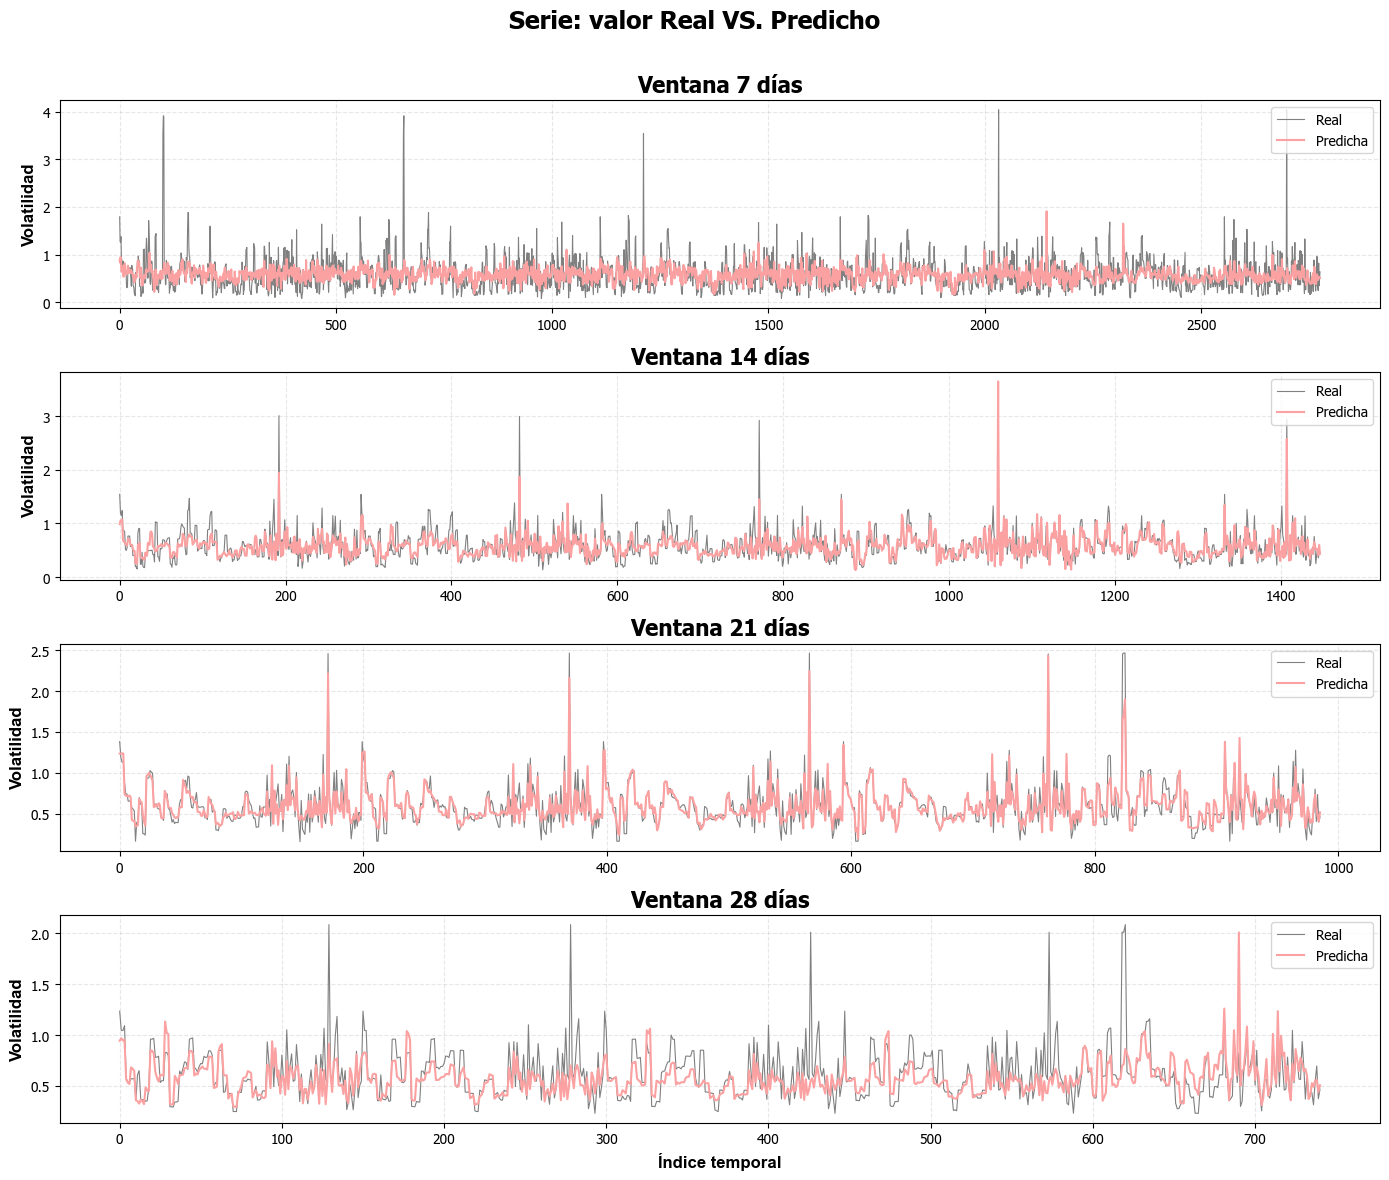

In [14]:
# [Gráfico] Serie de Real VS. Predicha

# Crear figura con subplots en una sola columna
fig, axes = plt.subplots(nrows=len(WINDOW_SIZES), ncols=1, figsize=(14, 12))

# Asegurar que axes sea iterable
if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]
    serie_real = []
    serie_pred = []

    for fr in folds:
        serie_real.extend(fr["y_train"])
        serie_real.extend(fr["y_val"])
        serie_real.extend(fr["y_test"])
        
        serie_pred.extend(fr["yhat_train"])
        serie_pred.extend(fr["yhat_val"])
        serie_pred.extend(fr["yhat_test"])

    # Convertir a arrays
    serie_real = np.array(serie_real)
    serie_pred = np.array(serie_pred)

    # Graficar en subplot correspondiente
    ax = axes[i]
    ax.plot(serie_real[:, -1], linestyle='-', color='grey', linewidth=0.8, label='Real')
    ax.plot(serie_pred[:, -1], linestyle='-', color='#FBA1A1', label='Predicha')

    ax.set_title(f'Ventana {ventana} días')
    if i == 3:
        ax.set_xlabel('Índice temporal', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)
fig.suptitle('Serie: valor Real VS. Predicho', fontsize=18, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig(f"figs/Serie_Valor_real_vs_predicho.png", dpi=300, bbox_inches="tight")
plt.show()

Para el valor predicho frente al real, se evidencia diferencias notorias entre las ventanas. La ventana de 7 días aunque logra captar la reactividad de la volatilidad, no es capaz de coincidir los eventos extremos. La ventana de 14 días mejora un poco esta condición, manejando mejor la predicción de eventos extremos. 

La ventana de 21 días es la que mejor predicción presenta, obteniendo valores muy parecidos a la real. Por su parte, la ventana de 28 días, tampoco logra capturar los eventos más abruptos en su mayoría.

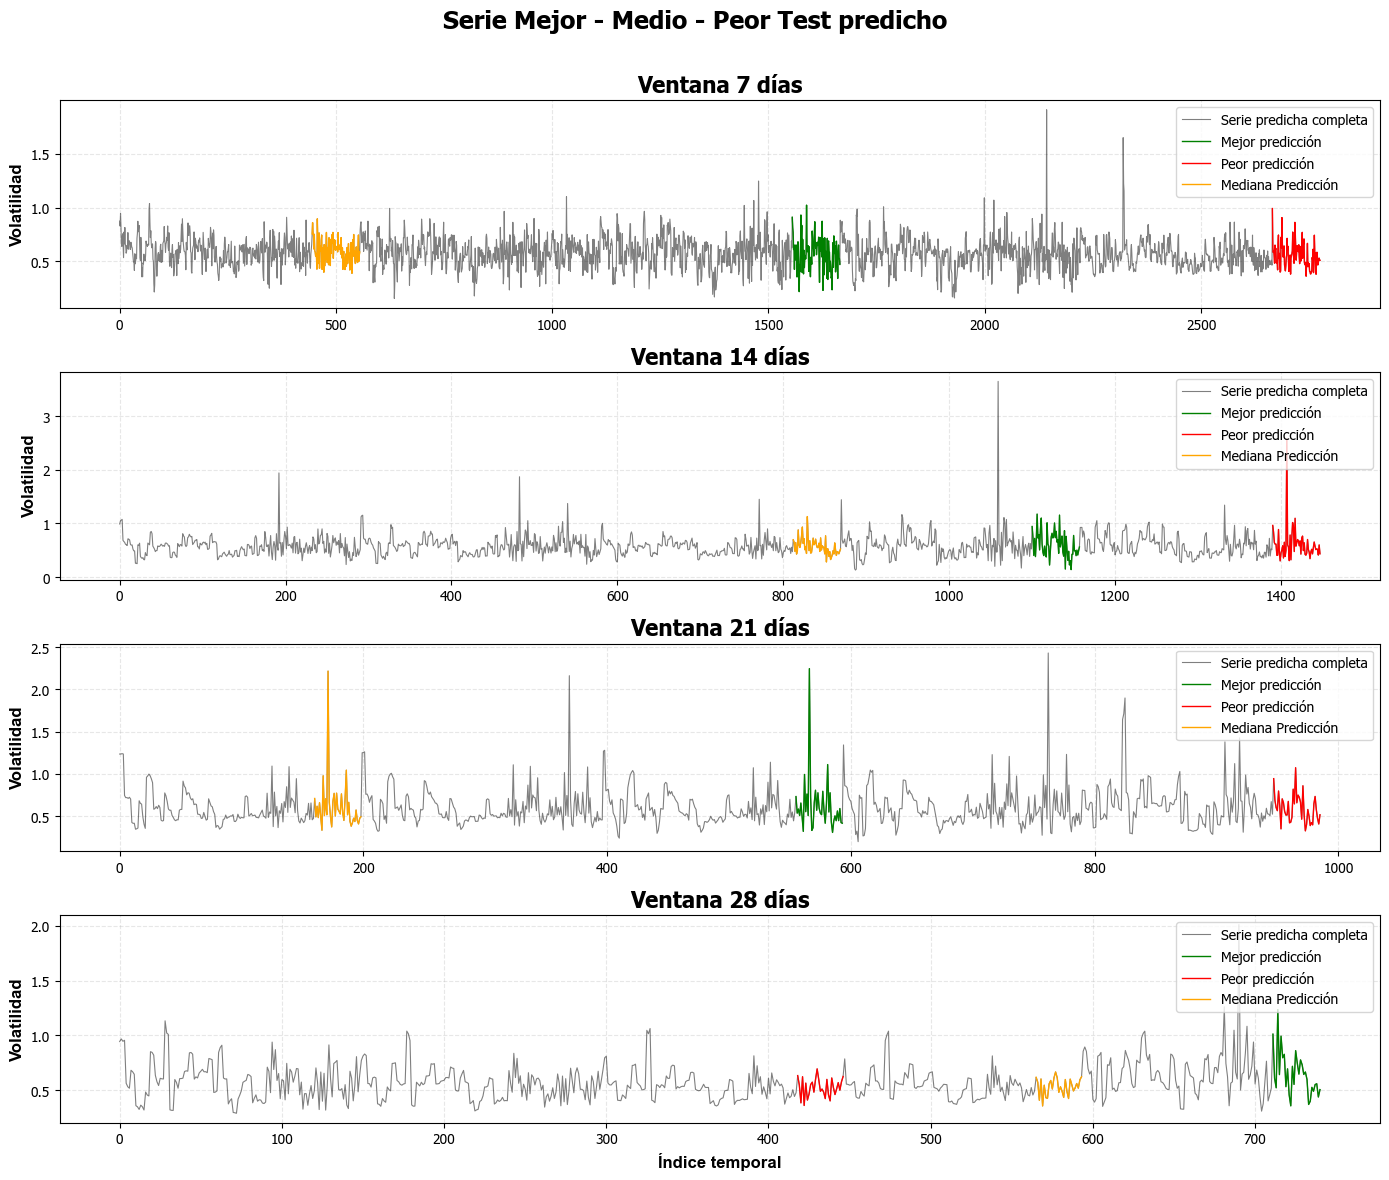

In [15]:
# [Gráfico] Mejor - Media - Peor fold de predicción

# Crear figura con subplots en una sola columna
fig, axes = plt.subplots(nrows=len(WINDOW_SIZES), ncols=1, figsize=(14,12))

# Asegurar que axes sea iterable
if len(WINDOW_SIZES) == 1:
    axes = [axes]

# Función auxiliar para calcular índice global del test
def obtener_indice_test(fold_obj, folds):
    idx = 0
    for fr in folds:
        n_train = len(fr['y_train'])
        n_val = len(fr['y_val'])
        n_test = len(fr['y_test'])
        if fr is fold_obj:
            return idx + n_train + n_val
        idx += n_train + n_val + n_test
    return None

# Iterar por ventana
for i, ventana in enumerate(WINDOW_SIZES):
    folds = results[ventana]["folds"]
    serie_pred = []

    for fr in folds:
        serie_pred.extend(fr["yhat_train"])
        serie_pred.extend(fr["yhat_val"])
        serie_pred.extend(fr["yhat_test"])

    serie_pred = np.array(serie_pred)

    # Obtener folds seleccionados
    best_fold = results[ventana]["best_fold"]
    worst_fold = results[ventana]["worst_fold"]
    medium_fold = results[ventana]["median_fold"]

    # Índices globales
    idx_best = obtener_indice_test(best_fold, folds)
    idx_worst = obtener_indice_test(worst_fold, folds)
    idx_medium = obtener_indice_test(medium_fold, folds)

    # Construir ejes
    x_best = np.arange(idx_best, idx_best + len(best_fold['yhat_test']))
    x_worst = np.arange(idx_worst, idx_worst + len(worst_fold['yhat_test']))
    x_medium = np.arange(idx_medium, idx_medium + len(medium_fold['yhat_test']))

    # Graficar en subplot correspondiente
    ax = axes[i]
    ax.plot(serie_pred[:, -1], linestyle='-', alpha=0.5, color='black', linewidth=0.8, label='Serie predicha completa')
    ax.plot(x_best, best_fold['yhat_test'][:, -1], label='Mejor predicción', color='green', linewidth=1)
    ax.plot(x_worst, worst_fold['yhat_test'][:, -1], label='Peor predicción', color='red', linewidth=1)
    ax.plot(x_medium, medium_fold['yhat_test'][:, -1], label='Mediana Predicción', color='orange', linewidth=1)

    ax.set_title(f'Ventana {ventana} días')
    if i == 3:
        ax.set_xlabel('Índice temporal', fontsize=12, fontweight='bold', fontname='Arial')
    ax.set_ylabel('Volatilidad', fontsize=12, fontweight='bold', fontname='Arial')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.3)

fig.suptitle('Serie Mejor - Medio - Peor Test predicho', fontsize=18, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/Serie_MMP_test_predicho.png", dpi=300, bbox_inches="tight")
plt.show()

En cuanto a las predicciones en el conjunto de test por cada fold, en su mayoría el peor fol es la predicción hacia el final de la serie, excepto para la ventana de 28 días. 

El mejor fold en todas las ventanas logran capturan tanto la variabilidad como los eventos extremos de la volatilidad. 

_______________

### Métricas

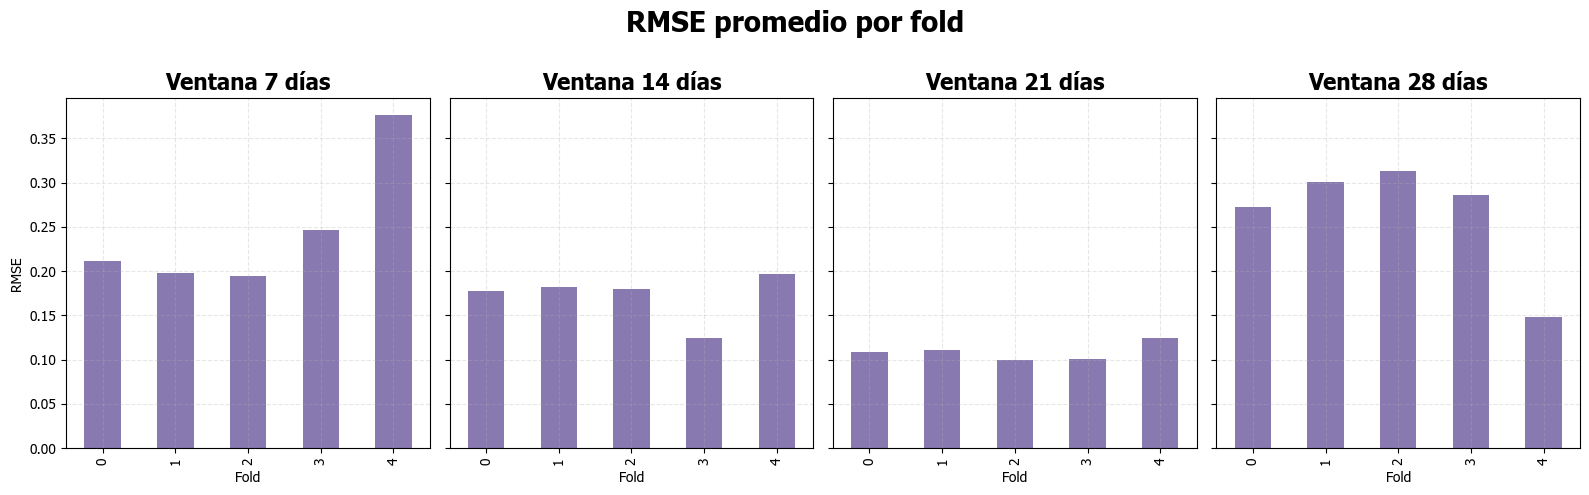

In [16]:
# [Gráfico] RMSE promedio por fold
fig, axes = plt.subplots(1, len(WINDOW_SIZES), figsize=(16, 5), sharey=True)

if len(WINDOW_SIZES) == 1:
    axes = [axes]

for i, window_size in enumerate(WINDOW_SIZES):
    df_metrics = results[window_size]["metrics"]

    # Filtrar solo horizonte "avg"
    RMSE_folds = df_metrics[df_metrics["Horizon"] == "avg"]
    RMSE_folds = RMSE_folds.set_index("fold")["RMSE"]

    # Graficar
    RMSE_folds.plot(kind="bar", ax=axes[i], color='#8879B0')
    axes[i].set_title(f"Ventana {window_size} días")
    axes[i].set_ylabel("RMSE" if i == 0 else "")
    axes[i].set_xlabel("Fold")
    axes[i].grid(True, linestyle='--', alpha=0.3)

fig.suptitle(f"RMSE promedio por fold", fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"figs/{objetivo}_RMSE_promedio_folds.png", dpi=300, bbox_inches="tight")
plt.show()


El gráfico muestra el comportamiento del error RMSE para los 5 folds generados por ventana, este mide el error promedio cuadrático entre la predicción y el valor real, entre más bajo es mejor. 

En este caso, la ventana de 21 días es la que mejor rendimiento muestra, al obtener los valores más bajos y menos variables entre los folds. En comparación, la ventana de 7 días junto con la de 28 días tienen las mayores variaciones, siendo más sensibles y menos estables. 

Los modelos evaluados presentan mejor precisión en ventanas intermedias (14 y 21 días), con RMSE bajo y estable entre folds. Las ventanas cortas (7 días) capturan mejor la reactividad pero con mayor error, mientras que las largas (28 días) suavizan demasiado y pierden sensibilidad en algunos folds. 

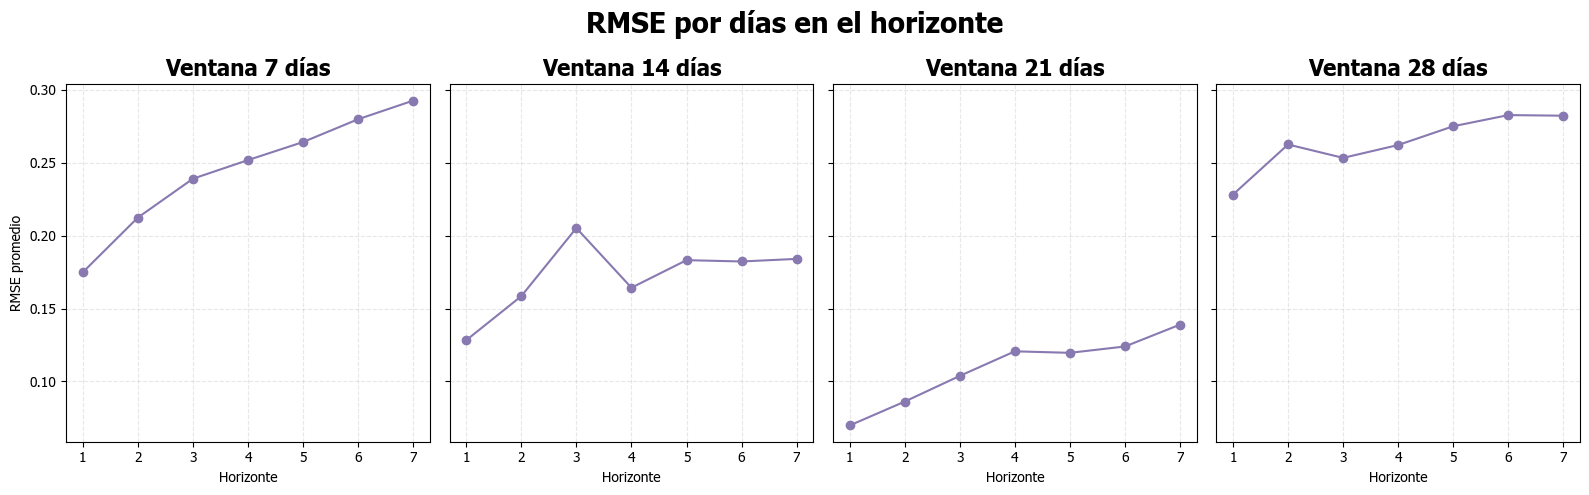

In [17]:
# [Gráfico] RMSE por días en el horizonte
fig, axes = plt.subplots(1, len(WINDOW_SIZES), figsize=(16, 5), sharey=True)

for ax, window_size in zip(axes, WINDOW_SIZES):
    
    df_metrics = results[window_size]["metrics"]
    df_metrics = df_metrics.copy()

    # Filtrar horizontes numéricos
    df_metrics = df_metrics[pd.to_numeric(df_metrics["Horizon"], errors="coerce").notna()]
    df_metrics["Horizon"] = df_metrics["Horizon"].astype(int)

    # Promedio por horizonte
    df_summary = (
        df_metrics.groupby("Horizon")["RMSE"]
        .mean()
        .reset_index()
    )

    # Graficar
    ax.plot(df_summary["Horizon"], df_summary["RMSE"], marker="o", color='#8879B0')
    ax.set_title(f"Ventana {window_size} días")
    ax.set_xlabel("Horizonte")
    ax.grid(True, linestyle='--', alpha=0.3)

# Eje Y compartido
axes[0].set_ylabel("RMSE promedio")


fig.suptitle(f"RMSE por días en el horizonte", fontsize=20, fontweight='bold', fontname='Tahoma')
plt.tight_layout()
plt.savefig(f"figs/{objetivo}_RMSE_promedio_horizontes.png", dpi=300, bbox_inches="tight")
plt.show()


______________

## Conclusión

> Para predecir la volatilidad anualizada en un horizonte de 7 días, la ventana de 21 días presenta mejor rendimiento global, siendo la que menor error comete en las predicciones, captando de mejor manera la variabilidad de la volatilidad.